In [1]:
import subprocess
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colormaps
import imageio.v2 as imageio
import io
import numpy as np
import xarray as xr
from common import set_plot_style, load_font

In [2]:
ROOT_FOLDER = Path("/home/robin/projects/TEDx/")

file_nc = (
    ROOT_FOLDER / "data" / "Mosquito" / "mosquito_seas_rcp85_mean_v1.0.nc"
)
variable = "season_length"

countries_vectorial = Path(
    ROOT_FOLDER / "data" / "countries_boundaries" / "CNTR_BN_10M_2020_4326.geojson"
)
countries_name = Path(
    ROOT_FOLDER / "data" / "countries_boundaries" / "CNTR_AT_2020.csv"
)

images_dir = Path(ROOT_FOLDER / "output" / "images" / "mosquito_season_length")
images_dir.mkdir(parents=True, exist_ok=True)

gif_dir = Path(ROOT_FOLDER / "output" / "gif" / "mosquito_season_length")
gif_dir.mkdir(parents=True, exist_ok=True)

lat_min, lat_max = 35, 47
lon_min, lon_max = 5, 20

set_plot_style()
load_font()

In [3]:
ds = xr.open_dataset(file_nc)
ds = ds[variable].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

In [4]:
# Load world map data
world = gpd.read_file(countries_vectorial)
world_names = gpd.pd.read_csv(countries_name)
world = world.join(world_names.set_index("CNTR_ID"), on="CNTR_CODE", how="left")

# Filter for Mediterranean countries
mediterranean_countries = [
    "Spain",
    "France",
    "Italy",
    "Slovenia",
    "Croatia",
    "Bosnia and Herzegovina",
    "Montenegro",
    "Albania",
    "Greece",
    "Turkey",
    "Syria",
    "Lebanon",
    "Israel",
    "Egypt",
    "Libya",
    "Tunisia",
    "Algeria",
    "Morocco",
]
mediterranean = world[world["NAME_ENGL"].isin(mediterranean_countries)]

In [5]:
if variable == "suitability":
    vmin, vmax = 0, 100
else:
    vmin, vmax = ds.quantile([0.05, 0.95]).values

images = []

# Create the directory if it doesn't exist

for time in ds.time.values:
    print(time)
    fig, ax = plt.subplots(figsize=(5, 5))
    mediterranean.plot(ax=ax, color="black", zorder=5, linewidth=0.5)

    ds.sel(time=time, method="nearest").plot(
        cmap="Oranges",
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={
            "label": (
                "Indice di idoneità climatica (0-100)"
                if variable == "suitability"
                else "Durata della stagione delle zanzare tigre (giorni)"
            )
        },
    )
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel("Longitudine")
    ax.set_ylabel("Latitudine")
    ax.set_title(f"Anno {str(time)[:4]}")

    # Save the plot locally
    filename = images_dir / f"mosquito_{variable}_{str(time)[:4]}.png"
    plt.savefig(filename, format="png")
    plt.close(fig)
    images.append(imageio.imread(filename))

1986-01-01T00:00:00.000000000
1987-01-01T00:00:00.000000000
1988-01-01T00:00:00.000000000
1989-01-01T00:00:00.000000000
1990-01-01T00:00:00.000000000
1991-01-01T00:00:00.000000000
1992-01-01T00:00:00.000000000
1993-01-01T00:00:00.000000000
1994-01-01T00:00:00.000000000
1995-01-01T00:00:00.000000000
1996-01-01T00:00:00.000000000
1997-01-01T00:00:00.000000000
1998-01-01T00:00:00.000000000
1999-01-01T00:00:00.000000000
2000-01-01T00:00:00.000000000
2001-01-01T00:00:00.000000000
2002-01-01T00:00:00.000000000
2003-01-01T00:00:00.000000000
2004-01-01T00:00:00.000000000
2005-01-01T00:00:00.000000000
2006-01-01T00:00:00.000000000
2007-01-01T00:00:00.000000000
2008-01-01T00:00:00.000000000
2009-01-01T00:00:00.000000000
2010-01-01T00:00:00.000000000
2011-01-01T00:00:00.000000000
2012-01-01T00:00:00.000000000
2013-01-01T00:00:00.000000000
2014-01-01T00:00:00.000000000
2015-01-01T00:00:00.000000000
2016-01-01T00:00:00.000000000
2017-01-01T00:00:00.000000000
2018-01-01T00:00:00.000000000
2019-01-01

In [6]:
# Create and save the GIF
imageio.mimsave(gif_dir / f"mosquito_{variable}.gif", images, fps=2)

In [7]:
# reduce the size of the GIF
subprocess.run(
    f"gifsicle --colors 64 -O3 {gif_dir / f'mosquito_{variable}.gif'} -o {gif_dir / f'mosquito_{variable}_optimized.gif'}",
    shell=True,
    check=True,
)

gifsicle: warning: huge GIF, conserving memory (processing may take a while)


CompletedProcess(args='gifsicle --colors 64 -O3 /home/robin/projects/TEDx/output/gif/mosquito_season_length/mosquito_season_length.gif -o /home/robin/projects/TEDx/output/gif/mosquito_season_length/mosquito_season_length_optimized.gif', returncode=0)

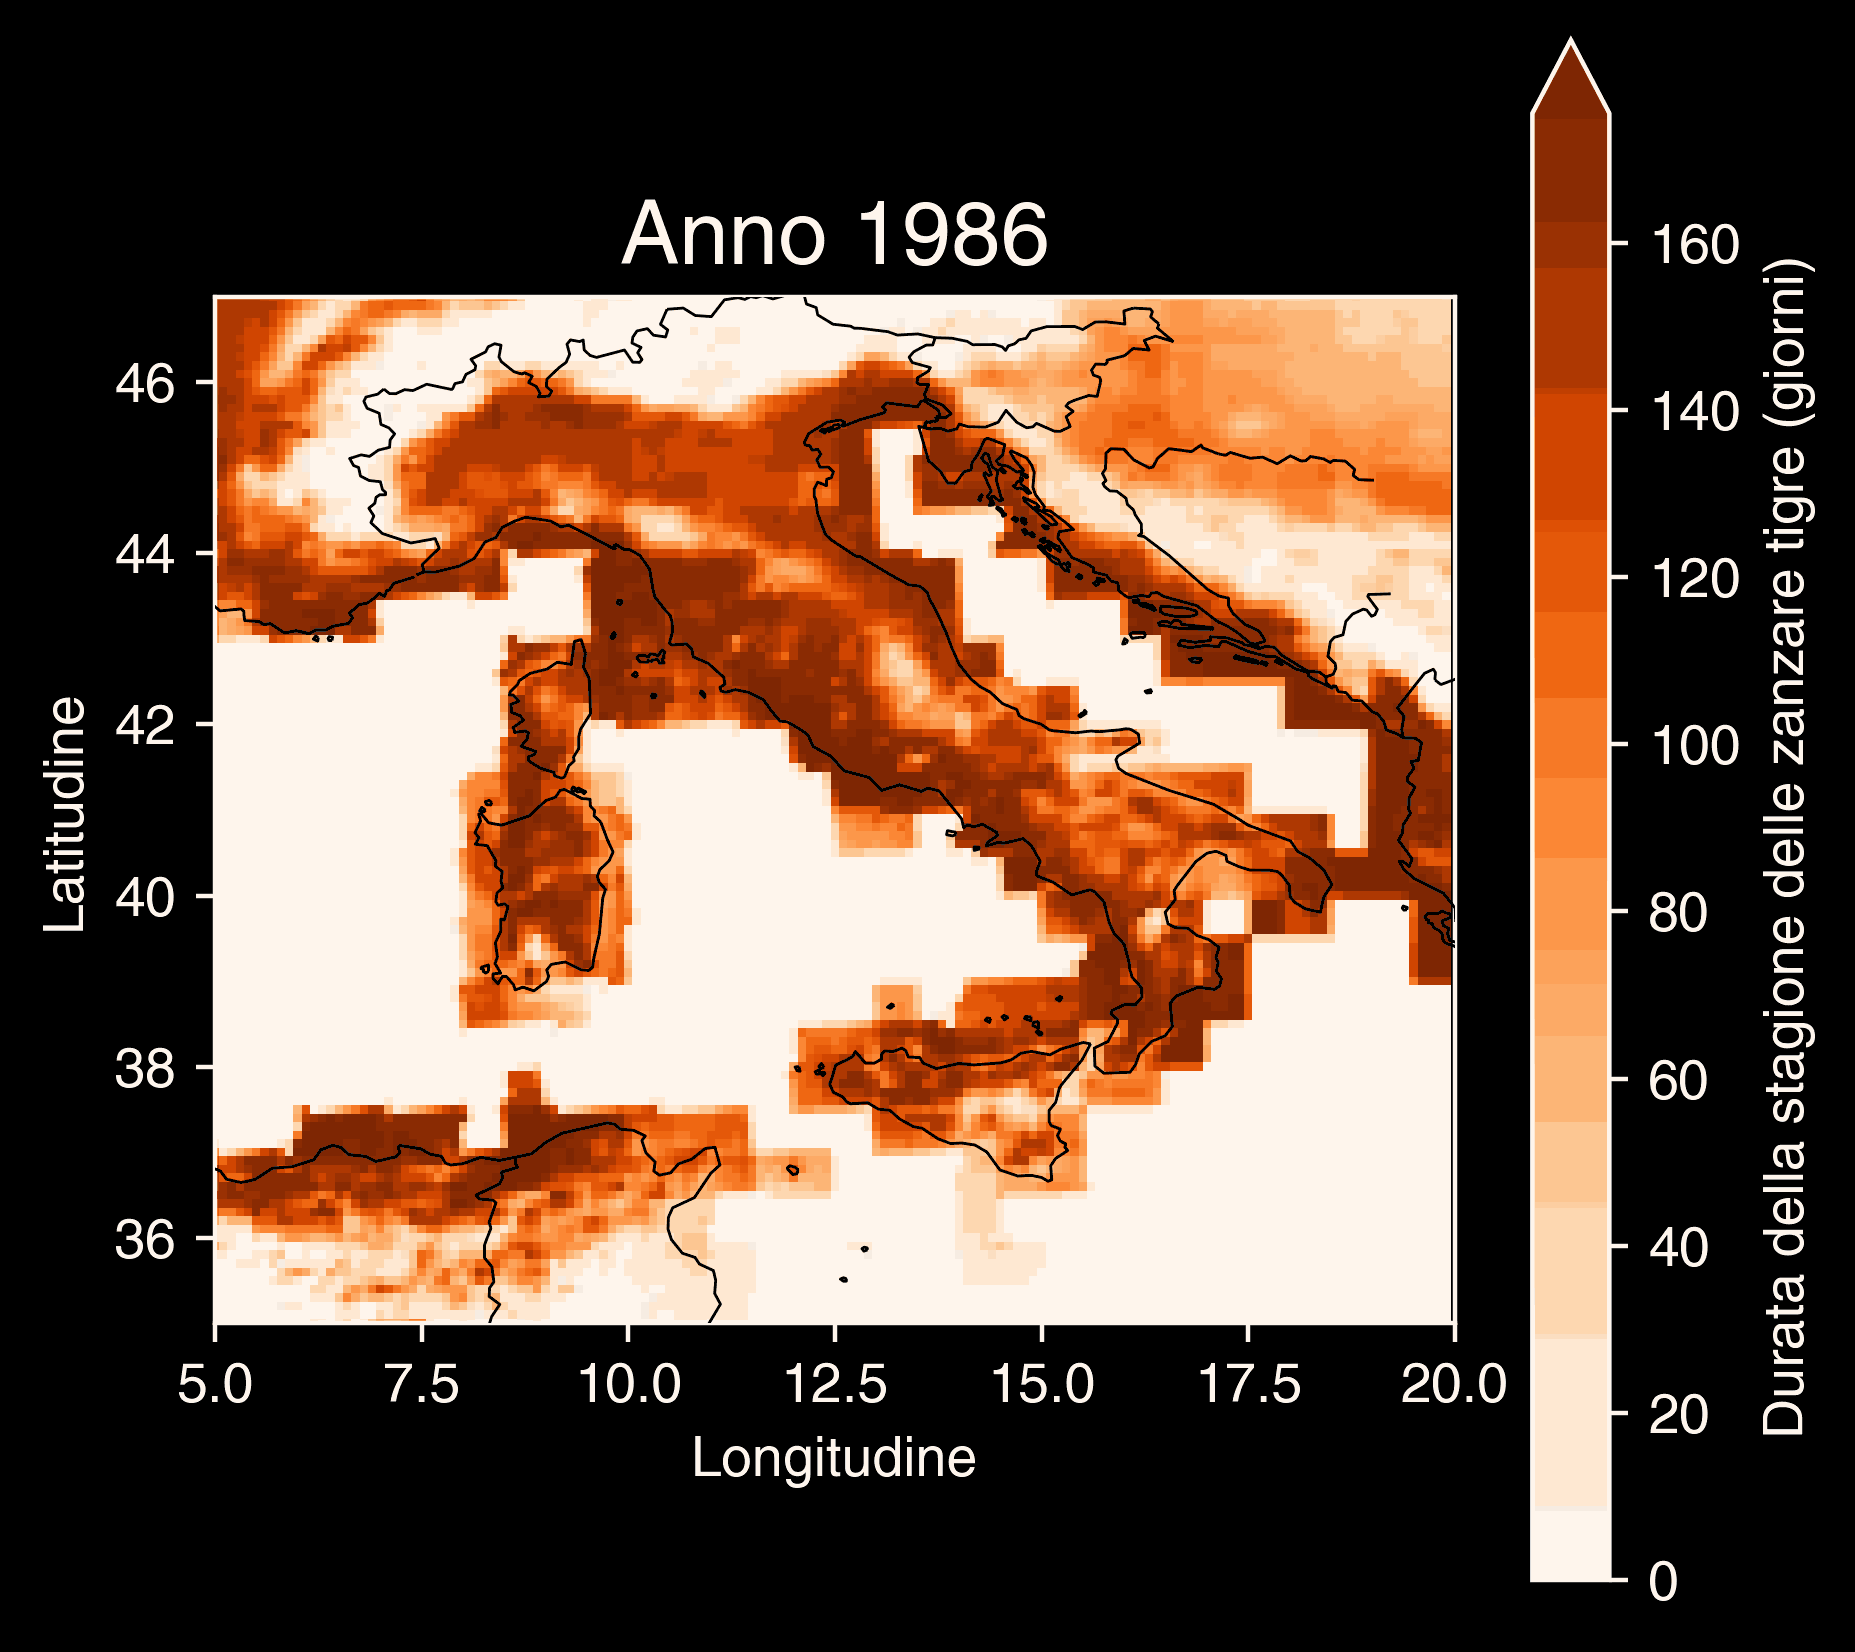

In [9]:
# Display the GIF
from IPython.display import Image

Image(filename=gif_dir / f"mosquito_{variable}_optimized.gif")
